In [1]:
%matplotlib widget
%load_ext autoreload
import numpy as np
import matplotlib, matplotlib.font_manager
import os
font_dirs = []
for searchdir in ["/usr/share/fonts", "/usr/share/texmf/fonts"]:
    for dirpath, dirnames, filenames in os.walk(searchdir):
        for subdir in dirnames:
            fulldir=os.path.join(dirpath, subdir)
            if not (fulldir in font_dirs):
                font_dirs.append(fulldir)
print(font_dirs)
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=font_dirs)
matplotlib.rcParams.update({ "pgf.texsystem": "pdflatex", 'font.family': 'serif', 'pgf.rcfonts': False,
                            "savefig.transparent" : True,  "svg.fonttype": 'none',  })
import matplotlib.pyplot as plt
plt.rc('pgf', texsystem='pdflatex')
plt.rc('font', family='serif')
plt.rc('savefig', bbox='tight')
plt.rc('savefig', transparent=True)
plt.rc('text', usetex=True)
plt.rc("svg", fonttype='none')
plt.rc('text.latex', preamble=
       r'\usepackage{amsmath}'\
       + "\n" + r'\usepackage{amssymb}'
       )
import matplotlib.figure, matplotlib.axes
import sys
import numpy as np
import pickle as pkl
import tqdm
import collections.abc
import torch
from utils import PredictionResults, color
import matplotlib.transforms
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.patches
import matplotlib.axes
import matplotlib.figure
from matplotlib.gridspec import GridSpec
from scipy.spatial.transform import Rotation

deepracing_path = os.environ["DEEPRACING_PATH"]
deepracingmodelsdir = os.path.abspath(os.path.join(deepracing_path, "DCNN-Pytorch"))
deepracingdir = os.path.abspath(os.path.join(deepracing_path, "deepracing_py"))
if (not (deepracingmodelsdir in sys.path)) or (not (deepracingdir in sys.path)):
    sys.path = [deepracingmodelsdir, deepracingdir] + sys.path
homedir = os.environ["HOME"]
mtrdir=os.path.join(homedir, "deepracingws", "MTR")
if (not (mtrdir in sys.path)):
    sys.path.insert(0, mtrdir)
print(os.getenv("PYTHONPATH"))
from utils import scatter_composite_axes, scatter_composite_xy
from deepracing_models.data_loading import SubsetFlag
import deepracing_models.math_utils as mu
import deepracing_models.data_loading.file_datasets as FD
import deepracing_models.data_loading.utils.file_utils as file_utils
import torch.utils.data as torchdata
import yaml 

['/usr/share/fonts/cmap', '/usr/share/fonts/truetype', '/usr/share/fonts/opentype', '/usr/share/fonts/X11', '/usr/share/fonts/cMap', '/usr/share/fonts/type1', '/usr/share/fonts/cmap/adobe-korea1', '/usr/share/fonts/cmap/adobe-japan1', '/usr/share/fonts/cmap/adobe-cns1', '/usr/share/fonts/cmap/adobe-gb1', '/usr/share/fonts/cmap/adobe-japan2', '/usr/share/fonts/truetype/dejavu', '/usr/share/fonts/truetype/noto', '/usr/share/fonts/truetype/droid', '/usr/share/fonts/truetype/lato', '/usr/share/fonts/truetype/liberation', '/usr/share/fonts/opentype/urw-base35', '/usr/share/fonts/X11/misc', '/usr/share/fonts/X11/Type1', '/usr/share/fonts/X11/encodings', '/usr/share/fonts/X11/util', '/usr/share/fonts/X11/encodings/large', '/usr/share/fonts/type1/urw-base35', '/usr/share/fonts/type1/gsfonts', '/usr/share/fonts/type1/texlive-fonts-recommended', '/usr/share/texmf/fonts/source', '/usr/share/texmf/fonts/afm', '/usr/share/texmf/fonts/enc', '/usr/share/texmf/fonts/map', '/usr/share/texmf/fonts/tfm',

In [2]:

keys : set = {
    "hist",
    "hist_tangents",
    "hist_quats",
    "hist_vel",
    "fut",
    "fut_quats",
    "fut_vel",
    "fut_tangents",
    "left_bd",
    "right_bd",
    "future_left_bd",
    "future_right_bd",
    "future_left_bd_tangents",
    "future_right_bd_tangents",
    "thistory",
    "tfuture",
    "current_position",
    "current_orientation",
    "future_left_bd_arclength",
    "future_right_bd_arclength",
    "future_centerline_arclength",
    "future_raceline_arclength",
    "future_arclength"
}
with open("config.yaml", "r") as f:
    configdict : dict = yaml.safe_load(f)
realdata : bool = configdict["realdata"]
data_dir = "/p/DeepRacing/unpacked_datasets/iac_data_v3/deepracing_standard" if realdata \
           else "/p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard"
mtr_data_dir = os.path.join(os.path.dirname(data_dir), "mtr_format", "1second")
dsets : list[FD.TrajectoryPredictionDataset] = \
    file_utils.load_datasets_from_files(data_dir,
                                     flag=SubsetFlag.TEST, keys=keys)
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)

if realdata:
    bezier_experiment = "registered_ottoman_7483"
    bezier_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/bezier_mixnet", bezier_experiment)
    composite_experiment = "musical_raccoon_7407" #encouraging_corolla_2210 musical_raccoon_7407
    composite_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/barte", composite_experiment)
    mixnet_experiment = "symbolic_varnish_9248"
    mixnet_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mixnet", mixnet_experiment)
    mtr_experiment = "worldwide_perch_1278"
    mtr_results_dir =  os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mtr", mtr_experiment)
else:
    bezier_experiment = "widespread_beans_6059"
    bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
    composite_experiment = "chosen_preservative_7505"
    composite_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
    mixnet_experiment = "agricultural_flue_8932"
    mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
    mtr_experiment = "formal_pedestal_9890"
    mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results/sim_data", mtr_experiment, "test_plots")


bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BézierMixNet")
bezier_results.compute_fde()

# composite_experiment = "sunny_coyote_3579"
composite_results = PredictionResults.from_data_file(os.path.join(composite_results_dir, "data.npz"), "BARTé")
composite_results.compute_fde()
composite_curves = torch.as_tensor(composite_results["curves"], dtype=torch.float64, device=torch.device("cpu"))
# if not realdata:
kbezier = composite_curves.shape[-2] - 1
num_segments = composite_curves.shape[-3]
tfuture_np = np.stack([fulldset[i]["tfuture"] for i in range(len(fulldset))], axis=0)
tfuture = torch.as_tensor(tfuture_np, dtype=composite_curves.dtype, device=composite_curves.device)
tfuture = tfuture - tfuture[:,[0,]]
tswitch = torch.stack([torch.linspace(tfuture[i,0], tfuture[i,-1], steps=num_segments+1, dtype=tfuture.dtype, device=tfuture.device) for i in range(tfuture.shape[0])], dim=0)
tstart = tswitch[:,:-1]
tend = tswitch[:,1:]
dt = tend - tstart
composite_curve_derivs = kbezier*(composite_curves[:,:,1:] - composite_curves[:,:,:-1])/(dt[:,:,None,None])
vels_eval, _ = mu.compositeBezierEval(tstart, dt, composite_curve_derivs, tfuture)
composite_results["vel_predictions"] = vels_eval.cpu().numpy()


mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
mixnet_results["ground_truth"] = np.stack([fulldset[i]["fut"].copy() for i in range(len(fulldset))], axis=0)
mixnet_results.compute_fde()

mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "data.npz"), "MTR")
mtr_results["predictions_all"] = mtr_results["predictions"].copy()
mtr_results["predictions"] = np.zeros_like(mtr_results["predictions_all"][:,0])
for idx in range(mtr_results["predictions_all"].shape[0]):
    mtr_results["predictions"][idx] = mtr_results["predictions_all"][idx,mtr_results["best_curve_idx"][idx]]
mtr_results.compute_fde()
# for k in ["history", "ground_truth"]

all_history = np.stack([fulldset[i]["hist"] for i in range(len(fulldset))], axis=0)
all_leftbound = np.stack([fulldset[i]["future_left_bd"] for i in range(len(fulldset))], axis=0)
all_rightbound = np.stack([fulldset[i]["future_right_bd"] for i in range(len(fulldset))], axis=0)
for result in [bezier_results, mtr_results, composite_results, mixnet_results]:
    result["left_bd"] = all_leftbound.copy()
    result["right_bd"] = all_rightbound.copy()
    print("%s has %d points" % (result.modelname, result["history"].shape[0]))
    print("%s has keys: %s" % (result.modelname, str(list(result.keys()))))


all_results_composite_ref = [composite_results, mtr_results, bezier_results, mixnet_results]
all_results_mtr_ref = [mtr_results, composite_results, bezier_results, mixnet_results]

Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_0/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_1/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_2/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_3/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_4/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_5/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepr

In [3]:
# whis=None
# pf=98.0
metric="ade"
cross_error_kwargs = {
    "metric" : metric,
    "pf" : 98.0
}
if realdata:
    results_base = "/p/DeepRacing/trajectory_prediction_results/plots/real_data"
else:
    results_base = "/p/DeepRacing/trajectory_prediction_results/plots/sim_data"
os.makedirs(results_base, exist_ok=True)

[113918, 69634, 93685, 51780, 57128]


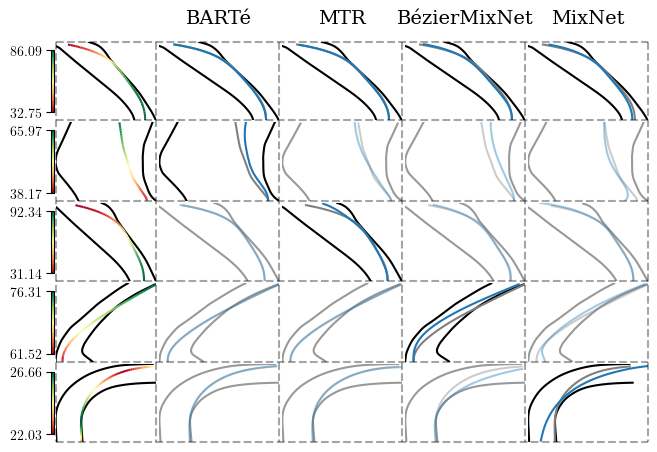

In [4]:
%autoreload 2
from utils import export_legend
mask = np.ones_like(fulldset[0]["future_left_bd"])
mask[:,2] = 0.0
plt.close('all')

rotation = Rotation.from_rotvec([0.0, 0.0, 90.0], degrees=True)
if realdata:
    # random_samples = np.asarray([1948, 8261, 4934, 9637, 6114, 522], dtype=np.int64) # (2,3) grid, real data
    random_samples = np.asarray([7948, 1324, 5270, 9519, 776, ], dtype=np.int64) # (2,3) grid, real data 6536
    
else:
    random_samples = np.asarray([113918, 69634, 93685, 51780, 57128], dtype=np.int64) # (2,3) grid, sim data  49583, 
#     random_samples = np.asarray([8387, 9498, 82174, 117623, 9113, 69920], dtype=np.int64) # (2,3) grid, sim data
# random_samples = np.random.randint(0, high=len(fulldset), size=(6,))
# 
print(random_samples.tolist())
grid_size = (random_samples.shape[0], len(all_results_composite_ref) + 1)
num_plots = grid_size[0]*grid_size[1]
figure_aspect_ratio = 16.0/9.0
height = 4.0
width = height*figure_aspect_ratio - 1.0
figsize = (width, height)
fig_grid, _ax_ = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
axes_grid : np.ndarray = _ax_
from utils import plot_example
for i in range(random_samples.shape[0]):
    sample = fulldset[random_samples[i]]
    gt_axes : matplotlib.axes.Axes = axes_grid[i,0]
    colorbar_label = "Speed (m/s)" if i==int(random_samples.shape[0]/2) else None
    plot_example(gt_axes, sample, rotation=rotation, cmap="RdYlGn")#, colorbar_label=colorbar_label)
    gt_axes.set_axis_off()
    for (j_, results) in enumerate(all_results_composite_ref):
        j = j_ + 1
        alpha = 1.0 if (i in [0, j]) else 0.4
        result_axes : matplotlib.axes.Axes = axes_grid[i,j]
        plot_example(result_axes, sample, predictions = results["predictions"][random_samples[i]][:,[0,1]], rotation=rotation, alpha=alpha)
        result_axes.set_axis_off()

# metadata={"dataset" : "real" if realdata else "sim", "indices" : random_samples.tolist(), "data_dir" : data_dir}
metadata : dict = {k : None for k in ['Creator', 'Date', 'Format', 'Type']}
metadata["Creator"] = "Trent Weiss"
# metadata["Keywords"] = ["real" if realdata else "sim",] + [str(i) for i in random_samples]
# metadata["Source"] = data_dir
fig_grid.tight_layout(pad = 0.0) #
fig_grid.subplots_adjust(wspace = 0.03, hspace = 0.03, left = 0.0, right = 1.0, bottom = 0.0, top = 1.0)
# fig_grid.
vertical_margin = 0.0
horizontal_margin = 0.00
import matplotlib.lines as lines
for i in range(grid_size[0]):
    p0_transform, pf_transform = axes_grid[i,0].transAxes + fig_grid.transFigure.inverted(), axes_grid[i,-1].transAxes + fig_grid.transFigure.inverted()
    p0, pf = p0_transform.transform([0.0, 0.0]),  pf_transform.transform([1.0 , 0.0])
    fig_grid.add_artist(lines.Line2D([p0[0], pf[0]], [p0[1], pf[1]], linestyle="--", color="black", alpha=0.35))
    # xtrans = fig_grid.transFigure
    # ytrans = axes_grid[i,0].transAxes
    # blended_trans  = matplotlib.transforms.blended_transform_factory(xtrans, ytrans)
    # fig_grid.add_artist(lines.Line2D([0.0, 1.0], np.zeros(2), linestyle="--", color="black", alpha=0.35, transform=blended_trans))
for i in range(grid_size[1]-1):
    p0_transform, pf_transform = axes_grid[0,i].transAxes + fig_grid.transFigure.inverted(), axes_grid[-1,i].transAxes + fig_grid.transFigure.inverted()
    p0, pf = p0_transform.transform([1.0, 1.0]),  pf_transform.transform([1.0 , 0.0])
    fig_grid.add_artist(lines.Line2D([p0[0], pf[0]], [p0[1], pf[1]], linestyle="--", color="black", alpha=0.35))
    # xtrans = axes_grid[0,i].transAxes
    # ytrans = fig_grid.transFigure
    # blended_trans  = matplotlib.transforms.blended_transform_factory(xtrans, ytrans)
    # fig_grid.add_artist(lines.Line2D(np.zeros(2), [0.0, 1.0], linestyle="--", color="black", alpha=0.35, transform=blended_trans))

p0_transform, pf_transform = axes_grid[0,-1].transAxes + fig_grid.transFigure.inverted(), axes_grid[-1,-1].transAxes + fig_grid.transFigure.inverted()
p0, pf = p0_transform.transform([1.0, 1.0]),  pf_transform.transform([1.0, 0.0])
fig_grid.add_artist(lines.Line2D([p0[0], pf[0]], [p0[1], pf[1]], linestyle="--", color="black", alpha=0.35))

p0_transform, pf_transform = axes_grid[0,0].transAxes + fig_grid.transFigure.inverted(), axes_grid[0,-1].transAxes + fig_grid.transFigure.inverted()
p0, pf = p0_transform.transform([0.0, 1.0]),  pf_transform.transform([1.0, 1.0])
fig_grid.add_artist(lines.Line2D([p0[0], pf[0]], [p0[1], pf[1]], linestyle="--", color="black", alpha=0.35))

p0_transform, pf_transform = axes_grid[0,0].transAxes + fig_grid.transFigure.inverted(), axes_grid[-1,0].transAxes + fig_grid.transFigure.inverted()
p0, pf = p0_transform.transform([0.0, 1.0]),  pf_transform.transform([0.0, 0.0])
fig_grid.add_artist(lines.Line2D([p0[0], pf[0]], [p0[1], pf[1]], linestyle="--", color="black", alpha=0.35))

# for i in range(1, grid_size[0]):
#     j=i
#     if j>=grid_size[1]:
#         continue
#     ax_highlight : matplotlib.axes.Axes = axes_grid[i,j]
#     all_points=[]
#     for line in ax_highlight.lines:
#         if (line.get_label()[0]!="_"):
#             all_points.append(np.stack([line.get_xdata(), line.get_ydata()], axis=1))
#     all_points = np.concatenate(all_points, axis=0)
#     rect = matplotlib.patches.Rectangle(p0, delta[0], delta[1], linewidth=1.5, edgecolor='black', facecolor='none', transform=ax_highlight.transAxes)
#     ax_highlight.add_patch(rect)


outfile = os.path.join(results_base, "examples_%s" % ("real" if realdata else "sim",)) 
with plt.rc_context({"savefig.format": "svg", "text.usetex" : False}) as ctx:
    ax01 : matplotlib.axes.Axes = axes_grid[0,1]
    fig_legend, ax_legend, bbox_legend = export_legend(ax01, singlerow=True, sort_keys=True, labelspacing=0.025, fontsize=14, columnspacing=0.5, handletextpad=0.1)
    fig_legend.savefig(outfile + "_predictions_legend", bbox_inches=bbox_legend, dpi="figure", transparent=True)
    plt.close(fig=fig_legend)

with plt.rc_context({"savefig.format": "svg", "text.usetex" : False}) as ctx:
    ax00 : matplotlib.axes.Axes = axes_grid[0,0]
    fig_legend, ax_legend, bbox_legend = export_legend(ax00, sort_keys=True, labelspacing=0.025, fontsize=14, columnspacing=0.5, handletextpad=0.1)
    fig_legend.savefig(outfile + "_groundtruth_legend", bbox_inches=bbox_legend, dpi="figure", transparent=True)
    plt.close(fig=fig_legend)

for i in range(1, grid_size[1]):
    results = all_results_composite_ref[i-1]
    ax : matplotlib.axes.Axes = axes_grid[0,i]
    title = ax.set_title(results.modelname, usetex=False, fontsize = 14, y=1.2)
    title.set_horizontalalignment("center")
    title.set_verticalalignment("center")

pad_inches = 1.0/25.4
with plt.rc_context({"savefig.format": "svg", "savefig.orientation" : "landscape", "savefig.pad_inches" : pad_inches}) as ctx:
    fig_grid.savefig(outfile, edgecolor=fig_grid.get_edgecolor(),  metadata=metadata)
# plt.close(fig=fig_grid)
# 113918, 69634, 49583, 57128, 51780, 93685 sim
# 1948,   8261,  4934,  9637,  6114,  522   real
# 7948 1324 5270 9519 776 6536

In [5]:


import shutil

rcparams_latex = {
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
}

plots_dir = os.path.join(results_base, "plots")
histograms_dir = os.path.join(results_base, "histograms")
plots_dir_trimmed = os.path.join(results_base, "plots_trimmed")
histograms_dir_trimmed = os.path.join(results_base, "histograms_trimmed")

In [6]:
from utils import create_table
from texttable import Texttable

results_textable = create_table([composite_results, mtr_results, mixnet_results, bezier_results])
results_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
print(results_textable.draw())
# results_trimmed_textable = create_table([composite_results_trimmed, mtr_results_trimmed, mixnet_results_trimmed, bezier_results_trimmed])
# results_trimmed_textable.set_deco(Texttable.BORDER | Texttable.HLINES | Texttable.HEADER | Texttable.VLINES)
# print(results_trimmed_textable.draw())

+--------------+-------+-------+---------+--------------+
|    Model     |  ADE  |  FDE  | Lateral | Longitudinal |
|              |       |       |  Error  |    Error     |
+==============+=======+=======+=========+==============+
|    BARTé     | 0.504 | 1.008 |  0.283  |    0.348     |
+--------------+-------+-------+---------+--------------+
|     MTR      | 0.524 | 1.065 |  0.175  |    0.450     |
+--------------+-------+-------+---------+--------------+
|    MixNet    | 1.892 | 3.476 |  0.463  |    1.706     |
+--------------+-------+-------+---------+--------------+
| BézierMixNet | 0.775 | 0.720 |  0.541  |    0.412     |
+--------------+-------+-------+---------+--------------+


In [7]:

maindir = os.path.join(results_base, "cross_error_analysis")
basedir = os.path.join(maindir, metric)
os.makedirs(basedir, exist_ok=True)
barchart_dir =  os.path.join(results_base, "bar_charts", metric)
os.makedirs(barchart_dir, exist_ok=True)


In [8]:

total_samples = composite_results[metric].shape[0]

barte_nonoutliers, barte_maxval = composite_results.trim_percentiles(**{k : cross_error_kwargs[k] for k in {"metric", "pf"}})
mtr_nonoutliers, mtr_maxval = mtr_results.trim_percentiles(**{k : cross_error_kwargs[k] for k in {"metric", "pf"}})


# mtr_nonoutliers, mtr_maxval = mtr_results.trim_iqr(metric=metric, whis=whis)
# barte_nonoutliers, barte_maxval = composite_results.trim_iqr(metric=metric, whis=whis)


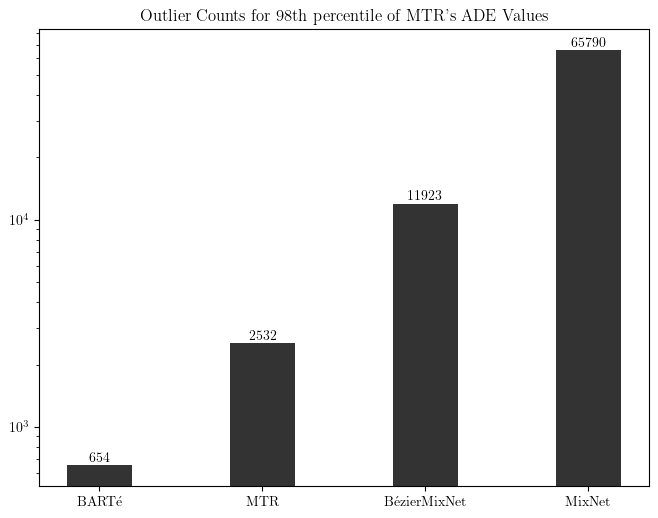

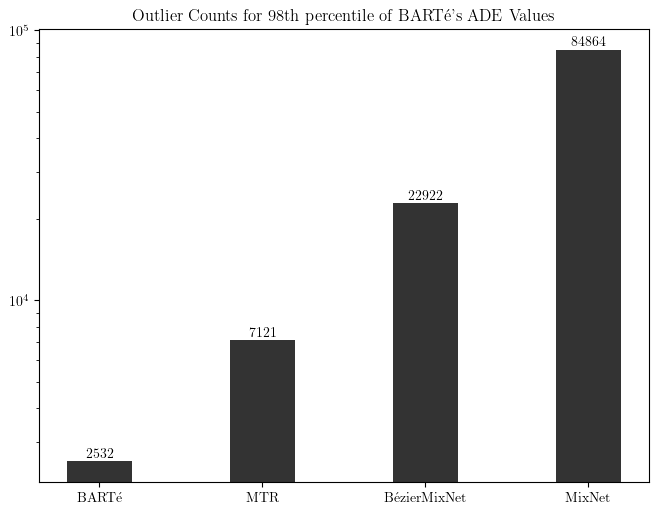

In [9]:

%autoreload 2
from utils import plot_outlier_counts
bar_kw = dict(
    color = "black",
    alpha = .8,
    width = .4,
    log=True
)
bar_label_kw = dict(
    padding = 1
)
figbar, axbar = plot_outlier_counts(all_results_composite_ref, metric, mtr_maxval, bar_kw=bar_kw, bar_label_kw=bar_label_kw)
axbar.set_title("Outlier Counts for 98th percentile of %s's ADE Values" % (mtr_results.modelname))
figbar2, axbar2 = plot_outlier_counts(all_results_composite_ref, metric, barte_maxval, bar_kw=bar_kw, bar_label_kw=bar_label_kw)
axbar2.set_title("Outlier Counts for 98th percentile of %s's ADE Values" % (composite_results.modelname))
with plt.rc_context({ "pgf.texsystem": "pdflatex", 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False,
                        "savefig.bbox" : "tight", "savefig.orientation" : "landscape",
                        "savefig.transparent" : True, "savefig.pad_inches" : 0.05, "svg.fonttype": 'none', 
                    }) as ctx:
    figbar.savefig(os.path.join(barchart_dir, "outlier_counts_mtr_maxval.svg"))
    figbar.savefig(os.path.join(barchart_dir, "outlier_counts_mtr_maxval.pgf"))

    figbar2.savefig(os.path.join(barchart_dir, "outlier_counts_barte_maxval.svg"))
    figbar2.savefig(os.path.join(barchart_dir, "outlier_counts_barte_maxval.pgf"))
# plt.show()

In [10]:
%autoreload 2
from utils import cross_error_analysis
print([res.modelname for res in all_results_composite_ref])
box_plot_maxes = 1.015*float(np.percentile(mixnet_results[metric], cross_error_kwargs["pf"]))
scale_ticks = np.linspace(0.02, box_plot_maxes, num=6).tolist() +\
            [
                0.5*(float(mixnet_results[metric].max()) + box_plot_maxes),
                1.025*float(mixnet_results[metric].max()),
            ]
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis(all_results_composite_ref, fulldset, basedir,
                     pf=None, whis=None, metric=metric, box_plot_scale="linear", vertlines=True,
                     box_plot_maxes=box_plot_maxes, scale_ticks=np.asarray(scale_ticks), individual_plots=False)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)
# plt.show()
# cross_error_analysis(all_results_mtr_ref, fulldset, basedir, pf=None, whis=None, metric=metric, histograms=False)

['BARTé', 'MTR', 'BézierMixNet', 'MixNet']
Not filtering


/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [11]:

%autoreload 2
from utils import cross_error_analysis
barte_inliers = composite_results[metric]<=mtr_maxval
mtr_inliers = mtr_results[metric]<=mtr_maxval
both_good = mtr_inliers*barte_inliers
box_plot_maxes = {res.modelname : 1.05*float(np.percentile(res[metric][both_good], cross_error_kwargs["pf"])) for res in [mtr_results, composite_results]}
box_plot_maxes[composite_results.modelname] = box_plot_maxes[mtr_results.modelname]
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     subdir="both_models_good_mtr_maxval", idx_filter=both_good, scale_ticks = np.linspace(0.0, 1.025*mtr_maxval, num=10),
                     pf=None, whis=None, metric=metric, vertlines=True, showfliers=False)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [12]:

%autoreload 2
from utils import cross_error_analysis
all_good = np.ones_like(mtr_results[metric], dtype=bool)
for res in all_results_composite_ref:
    current_good = res[metric]<=mtr_maxval
    all_good*=current_good
box_plot_maxes = {res.modelname : 1.05*float(np.percentile(res[metric][all_good], cross_error_kwargs["pf"])) for res in [mtr_results, composite_results]}
box_plot_maxes[composite_results.modelname] = box_plot_maxes[mtr_results.modelname]
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     subdir="all_models_good_barte_mtr_only_mtr_maxval", idx_filter=all_good,
                    pf=None, whis=None, metric=metric, vertlines=True, 
                    box_plot_maxes = box_plot_maxes)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [13]:

%autoreload 2
from utils import cross_error_analysis
all_good = np.ones_like(mtr_results[metric], dtype=bool)
for res in all_results_composite_ref:
    current_good = res[metric]<=mtr_maxval
    print("%s has %d outliers" % (res.modelname, int(np.sum(~current_good))))
    all_good*=current_good

box_plot_maxes = {res.modelname : 1.05*float(np.percentile(res[metric][all_good], cross_error_kwargs["pf"])) for res in all_results_composite_ref}
box_plot_maxes[composite_results.modelname] = box_plot_maxes[mtr_results.modelname]

(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis(all_results_composite_ref, fulldset, basedir, 
                     subdir="all_models_good_mtr_maxval", idx_filter=all_good,
                    pf=None, whis=None, metric=metric, vertlines=True, 
                    box_plot_maxes = box_plot_maxes, scale_ticks = np.linspace(0.0, 1.025*mtr_maxval, num=10))
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


BARTé has 654 outliers
MTR has 2532 outliers
BézierMixNet has 11923 outliers
MixNet has 65790 outliers


/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [14]:

%autoreload 2
from utils import cross_error_analysis

barte_inliers = composite_results[metric]<=barte_maxval 
mtr_inliers = mtr_results[metric]<=mtr_maxval
both_good = barte_inliers*mtr_inliers

(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric, subdir = "both_models_good_merged", idx_filter = both_good, 
                     scale_ticks = np.linspace(0.0, 1.025*mtr_maxval, num=10))
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)
# cross_error_analysis([barte_both_good, mtr_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric, histograms=False)

/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [15]:

%autoreload 2
from utils import cross_error_analysis

barte_inliers = composite_results[metric]<=barte_maxval 
mtr_inliers = mtr_results[metric]<=barte_maxval
both_good = barte_inliers*mtr_inliers
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric, vertlines=True, showfliers=False,
                       subdir = "both_models_good_barte_maxval", idx_filter = both_good,
                       scale_ticks = np.linspace(0.0, 1.025*barte_maxval, num=10))
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)
# cross_error_analysis([barte_both_good, mtr_both_good], dset_both_good, basedir, pf=None, whis=None, metric=metric, histograms=False)

/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [16]:
%autoreload 2
from utils import cross_error_analysis
histogram_ticks : list[float] = np.linspace(0.02, 2.33, num=4).tolist()
histogram_ticks.append(10.35)
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric, vertlines=True, histogram_ticks=np.asarray(histogram_ticks),
                       subdir = "baseline_only_barte_mtr", idx_filter = np.ones_like(mtr_results[metric], dtype=bool))
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)

/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [17]:
%autoreload 2
from utils import cross_error_analysis
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis(all_results_composite_ref, fulldset, basedir, other_models=[mtr_results.modelname,], **cross_error_kwargs)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis(all_results_mtr_ref, fulldset, basedir, other_models=[composite_results.modelname,], **cross_error_kwargs)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)

/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)
/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [18]:
%autoreload 2
from utils import cross_error_analysis
barte_outliers = composite_results[metric]>barte_maxval
mtr_outliers = mtr_results[metric]>mtr_maxval
both_bad = barte_outliers*mtr_outliers
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric,  vertlines=True, scale_ticks="linear",
                       subdir = "both_models_bad_merged", idx_filter = both_bad)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [19]:
%autoreload 2
from utils import cross_error_analysis
# plt.close("all")


barte_outliers = composite_results[metric]>barte_maxval
mtr_outliers = mtr_results[metric]>barte_maxval
both_bad = barte_outliers*mtr_outliers
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric,  vertlines=True, scale_ticks="linear",
                       subdir = "both_models_bad_barte_maxval", idx_filter = both_bad)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)


/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [20]:

# plt.close("all")
barte_outliers = composite_results[metric]>mtr_maxval
mtr_outliers = mtr_results[metric]>mtr_maxval
both_bad = barte_outliers*mtr_outliers
(fig_combined_histogram, axes_histogram),\
(fig_combined_boxplot, axes_list_boxplot),\
(fig_combined_violinplot, axes_list_violinplot) = cross_error_analysis([mtr_results, composite_results], fulldset, basedir, 
                     pf=None, whis=None, metric=metric,  vertlines=True, scale_ticks="linear",
                       subdir = "both_models_bad_mtr_maxval", idx_filter = both_bad)
plt.close(fig=fig_combined_boxplot)
plt.close(fig=fig_combined_histogram)
plt.close(fig=fig_combined_violinplot)

/l/ttw2xk/deepracingws/src/deepracing/DCNN-Pytorch/plotting/utils.py:356: UserWarning: The figure layout has changed to tight
  fig_combined_violinplot.tight_layout(pad=0.1)


In [21]:

# mtr_outliers = ~mtr_nonoutliers
# mtr_outliers_idx = np.where(mtr_outliers)[0]
mtr_argsort = np.flipud(np.argsort(mtr_results["ade"]))

dict_keys(['left_bd', 'current_orientation', 'future_right_bd_tangents', 'future_arclength', 'future_left_bd', 'current_position', 'hist_quats', 'future_centerline_arclength', 'hist', 'future_raceline_arclength', 'tfuture', 'future_left_bd_arclength', 'future_left_bd_tangents', 'future_right_bd_arclength', 'fut_tangents', 'hist_tangents', 'thistory', 'fut_quats', 'hist_vel', 'future_right_bd', 'fut', 'right_bd', 'fut_vel', 'trackname'])
(80, 2)
[ 39.4364738 -25.       ]
[0.68384762 0.47566048]


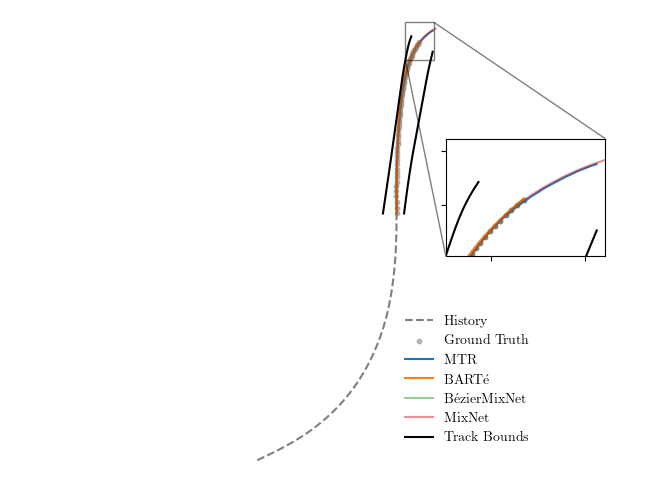

In [22]:
import os
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.axes
plt.rcParams["text.usetex"]=True
results_list = all_results_mtr_ref
ref_results = results_list[0]
alpha_dict = {res.modelname : 0.5 for res in results_list}
alpha_dict[composite_results.modelname] = 1.0 
alpha_dict[mtr_results.modelname] = 1.0 

# idx_rand = np.random.randint(0, high=len(fulldset))
idx_rand = mtr_argsort[7]
sample = fulldset[idx_rand]
print(sample.keys())
# Rmat = np.eye(2, dtype=sample["hist"].dtype)
Rmat = Rotation.from_rotvec([0.0, 0.0, np.pi/2.0]).as_matrix()[0:2,0:2]
history = (Rmat @ sample["hist"][:,[0,1]].T).T
ground_truth = (Rmat @ sample["fut"][:,[0,1]].T).T
future_left_bd = (Rmat @ sample["future_left_bd"][:,[0,1]].T).T
future_right_bd = (Rmat @ sample["future_right_bd"][:,[0,1]].T).T

artist_dict : dict[str,matplotlib.lines.Line2D | matplotlib.collections.PathCollection] = dict()
fig, _axmain_ = plt.subplots()
axmain : matplotlib.axes.Axes = _axmain_
history_label = "History"
artist_dict[history_label] = axmain.plot(history[:,0], history[:,1], label=history_label, linestyle="--", c="grey")[0]
ground_truth_label = "Ground Truth"
artist_dict[ground_truth_label] = axmain.scatter(ground_truth[:,0], ground_truth[:,1], label=ground_truth_label, c="grey", alpha=0.5, s=10.0)
print(ref_results["predictions"][idx_rand].shape)
mtr_predictions = (Rmat @ ref_results["predictions"][idx_rand][:,[0,1]].T).T
axes_to_data = axmain.transAxes + axmain.transData.inverted()
data_to_axes = axes_to_data.inverted()

# start_point_axes = data_to_axes.transform(mtr_predictions[-int(round(.35*mtr_predictions.shape[0]))])
# start_point_axes[0] = 0.0
start_point_axes = data_to_axes.transform(future_left_bd[-int(round(.15*mtr_predictions.shape[0]))])
start_point = axes_to_data.transform(start_point_axes)

end_point_axes = data_to_axes.transform(mtr_predictions[-1])
end_point_axes[0] += 1E-2
end_point_axes[1] += 3E-2
end_point = axes_to_data.transform(end_point_axes)

p0 = start_point - 10.0
pf = end_point + 7.5
delta = pf - p0
predictions_dict : dict[str,np.ndarray] = dict()
predictions_dict[mtr_results.modelname] = mtr_predictions
predictions_dict["Ground Truth"] = ground_truth
predictions_inset_dict : dict[str,np.ndarray] = dict()
p0deltas = mtr_predictions - p0[None]
pfdeltas = -mtr_predictions + pf[None]
p0deltas = ground_truth - p0[None]
pfdeltas = -ground_truth + pf[None]
ground_truth_inset = ground_truth[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
for (idx, results) in enumerate(results_list):
    predictions = (Rmat @ results["predictions"][idx_rand][:,[0,1]].T).T
    artist_dict[results.modelname] = axmain.plot(predictions[:,0], predictions[:,1], label=results.modelname, alpha=alpha_dict[results.modelname])[0]
    predictions_dict[results.modelname] = predictions.copy()
    p0deltas = predictions - p0[None]
    pfdeltas = -predictions + pf[None]
    predictions_inset_dict[results.modelname] = predictions[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
barte_predictions = predictions_dict[composite_results.modelname]
mixnet_predictions = predictions_dict[mixnet_results.modelname]

predictions_inset_dict["left_bound"] = future_left_bd[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()
predictions_inset_dict["right_bound"] = future_right_bd[np.prod(p0deltas>0.0, axis=1, dtype=bool)*np.prod(pfdeltas>0.0, axis=1, dtype=bool)].copy()

boundcolor="black"
left_bound_input = sample["left_bd"]
artist_dict["left_bound"] = axmain.plot(future_left_bd[:,0], future_left_bd[:,1], color=boundcolor, label="Track Bounds")[0]
right_bound_input = sample["right_bd"]
artist_dict["right_bound"] = axmain.plot(future_right_bd[:,0], future_right_bd[:,1], color=boundcolor)[0]
axmain.axis("equal")
#ground_truth[0] + 
fig.canvas.draw()
axes_to_data = axmain.transAxes + axmain.transData.inverted()
data_to_axes = axes_to_data.inverted()
inset_origin = future_right_bd[0] + np.asarray([35.0, -25.0], dtype=future_right_bd.dtype)
inset_origin_axes = data_to_axes.transform(inset_origin)
# inset_origin_axes = np.asarray([0.675, 0.4], dtype=ground_truth.dtype)
print(inset_origin)
print(inset_origin_axes)
axinset : matplotlib.axes.Axes = axmain.inset_axes(
    [
        inset_origin_axes[0], 
        inset_origin_axes[1], 
        0.25, 
        0.25
    ],
    xlim=(start_point[0], end_point[0]), ylim=(start_point[1], end_point[1]), xticklabels=[], yticklabels=[])
for (k, v) in predictions_inset_dict.items():
    mplobject = artist_dict[k]
    if type(mplobject) is matplotlib.collections.PathCollection:
        color = mplobject.get_facecolor()
    elif type(mplobject) is matplotlib.lines.Line2D:
        color = mplobject.get_color()
    else:
        raise ValueError("?")
    axinset.plot(v[:,0], v[:,1], label=k, color=color, alpha=mplobject.get_alpha())
axinset.scatter(ground_truth_inset[:,0], ground_truth_inset[:,1], label="Ground Truth", c="grey", alpha=1.0, s=10.0)
axmain.indicate_inset_zoom(axinset, edgecolor="black")
axmain.get_xaxis().set_ticks([])
axmain.get_yaxis().set_ticks([])
for pos in ['right', 'top', 'bottom', 'left']: 
    axmain.spines[pos].set_visible(False) 
historymin = np.min(history[:,0])
historymax = np.max(history[:,0])
axmain.set_xlim(historymin, historymax + 2.0) #fancybox=False, 
axmain.legend(frameon=False, loc="upper left", bbox_to_anchor=[0.6,0.375])
fig.tight_layout(pad=0.1)
fig.savefig(os.path.join(plots_dir, "example_predictions.pgf"), pad_inches=0.02)
fig.savefig(os.path.join(plots_dir, "example_predictions.pdf"), pad_inches=0.02)
plt.show()

In [23]:

# idx_rand = 48415
# idx_rand = 23654
# idx_rand = 106818
# idx_rand = 36336
# idx_rand = 83130
# idx_rand = 20194
# idx_rand = mtr_argsort[12]
idx_rand = mtr_argsort[np.random.randint(0, high=500)]# - 10
print(idx_rand)

105498


105498
dict_keys(['left_bd', 'current_orientation', 'future_right_bd_tangents', 'future_arclength', 'future_left_bd', 'current_position', 'hist_quats', 'future_centerline_arclength', 'hist', 'future_raceline_arclength', 'tfuture', 'future_left_bd_arclength', 'future_left_bd_tangents', 'future_right_bd_arclength', 'fut_tangents', 'hist_tangents', 'thistory', 'fut_quats', 'hist_vel', 'future_right_bd', 'fut', 'right_bd', 'fut_vel', 'trackname'])



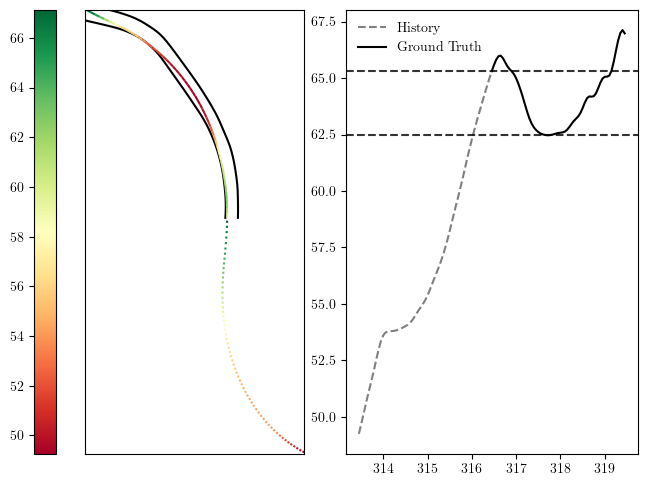

In [24]:


# idx_good = plot_outliers([composite_results, mtr_results, mixnet_results, bezier_results], plots_dir, fulldset, N=25, metric_key="ade", worst=False)



# sample = fulldset[idx_good[26]]
import matplotlib.transforms
from scipy.spatial.transform import Rotation
from matplotlib.collections import LineCollection, Collection
from matplotlib.colors import BoundaryNorm, ListedColormap, Colormap
from matplotlib.patches import ArrowStyle
import matplotlib.cm
import matplotlib.colorbar as cb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.axes, matplotlib.figure
import copy
from utils import add_colored_line, HandlerColorLineCollection

sample = fulldset[idx_rand]
print(idx_rand)
print(sample.keys())

Rmat = Rotation.from_rotvec([0.0, 0.0, 0.5*np.pi]).as_matrix()[0:2,0:2]
history_start = 0
history = (Rmat @ sample["hist"][history_start:,[0,1]].T).T
history_vels = (Rmat @ sample["hist_vel"][history_start:,[0,1]].T).T
history_speeds = np.linalg.norm(history_vels, ord=2.0, axis=1)
history_tangents = (Rmat @ sample["hist_tangents"][history_start:,[0,1]].T).T
#history_vels/history_speeds[:,None]

history_all_vels = (Rmat @ sample["hist_vel"][:,[0,1]].T).T
history_all_speeds = np.linalg.norm(history_all_vels, ord=2.0, axis=1)


ground_truth = (Rmat @ sample["fut"][:,[0,1]].T).T
ground_truth_vels = (Rmat @ sample["fut_vel"][:,[0,1]].T).T
ground_truth_speeds = np.linalg.norm(ground_truth_vels, ord=2.0, axis=1)

all_points = np.concatenate([history, ground_truth], axis=0)
all_speeds = np.concatenate([history_speeds, ground_truth_speeds], axis=0)




thistory = sample["thistory"]
tfuture = sample["tfuture"]
future_left_bd = (Rmat @ sample["future_left_bd"][:,[0,1]].T).T
future_right_bd = (Rmat @ sample["future_right_bd"][:,[0,1]].T).T
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
allpoints = np.concatenate([history, ground_truth], axis=0)
topleft = np.min(allpoints, axis=0) - 1.0
bottomright = np.max(allpoints, axis=0)# + 1.0
asdf : tuple[matplotlib.figure.Figure, list[matplotlib.axes.Axes]] = plt.subplots(1,2)
fig : matplotlib.figure.Figure = asdf[0]
ax : matplotlib.axes.Axes = asdf[1][0]
ax.set_xlim(topleft[0], bottomright[0])
ax.set_ylim(topleft[1], bottomright[1])
ax.plot(future_left_bd[:,0], future_left_bd[:,1], linestyle="solid", color="black")
boundaries = ax.plot(future_right_bd[:,0], future_right_bd[:,1], linestyle="solid", color="black")
norm = plt.Normalize(all_speeds.min(), all_speeds.max(), clip=True)
cmap = "RdYlGn"
scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
lc_hist, line_hist = add_colored_line(history, history_speeds[:-1], ax, cmap, linestyle="dotted")
lc_ground_truth, line_ground_truth  = add_colored_line(ground_truth, ground_truth_speeds[:-1], ax, cmap)
line_ground_truth.set_label("asdf")
lc_ground_truth.set_label("asdf")

os.makedirs(plots_dir, exist_ok=True)
ax.set_xticks([])
ax.set_yticks([])
ax_speed = asdf[1][1]
ax_speed.plot(thistory, history_all_speeds, label="History", linestyle="--", color="grey")
ax_speed.plot(tfuture, ground_truth_speeds, label="Ground Truth", color="black")
ax_speed.axhline(ground_truth_speeds.min(), xmin=0.0, xmax=1.0, linestyle="--", color="black", alpha=0.8)
ax_speed.axhline(history_all_speeds.max(), xmin=0.0, xmax=1.0, linestyle="--", color="black", alpha=0.8)
ax_speed.legend(frameon=False, fancybox=False)

ihistmax = np.argmax(history_all_speeds)
t_max_speed = thistory[ihistmax]
max_speed = history_all_speeds[ihistmax]

igtmin = np.argmin(ground_truth_speeds)
t_min_speed = tfuture[igtmin]
min_speed = ground_truth_speeds[igtmin]
average_acceleration=float((min_speed - max_speed)/(t_min_speed - t_max_speed))
accel_sign = np.sign(average_acceleration)
print()

#nu: ν eta: η
ax_speed.xaxis.tick_bottom()
# ax_speed.tick_params(axis="x", direction="in")
ax_speed.set_axisbelow(True)
fig.align_xlabels()
fig.tight_layout(pad=0.5)
colorbar : cb.Colorbar = fig.colorbar(scalar_mappable, ax=ax, location='left')
extent = ax.dataLim.transformed(fig.dpi_scale_trans.inverted())
fig.savefig(os.path.join(plots_dir, "label_onlyposition.svg"), bbox_inches=extent, pad_inches=0.02, transparent=True)
extent = ax_speed.get_tightbbox().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(os.path.join(plots_dir, "label_onlyspeed.svg"), bbox_inches=extent, pad_inches=0.02, transparent=True)
fig.savefig(os.path.join(plots_dir, "label.svg"), pad_inches=0.02, transparent=True)
plt.show()

/p/DeepRacing/trajectory_prediction_results/plots/sim_data/plots


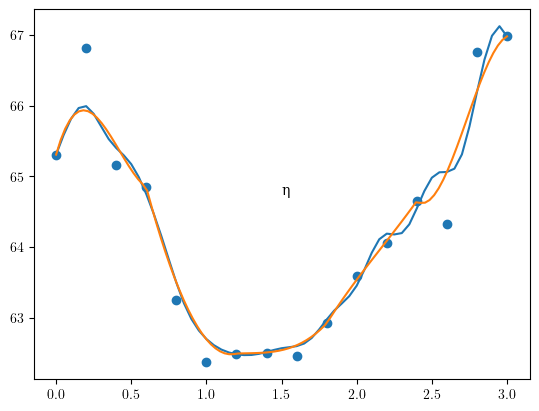

In [25]:
from scipy.interpolate import BSpline, make_interp_spline
Rmat = Rotation.from_rotvec([0.0, 0.0, 0.5*np.pi]).as_matrix()[0:2,0:2]
history_vels = torch.as_tensor((Rmat @ sample["hist_vel"][:,[0,1]].T).T, dtype=torch.float64)
history_speeds = torch.linalg.norm(history_vels, ord=2.0, axis=1)
ground_truth_vels = torch.as_tensor((Rmat @ sample["fut_vel"][:,[0,1]].T).T, dtype=history_vels.dtype)
ground_truth_speeds = torch.linalg.norm(ground_truth_vels, ord=2.0, axis=1)

thistory = torch.as_tensor(sample["thistory"], dtype=history_vels.dtype)
tfuture = torch.as_tensor(sample["tfuture"], dtype=history_vels.dtype)
scipyspline : BSpline = make_interp_spline(tfuture.cpu(), ground_truth_speeds.cpu())
dYdT_0 = torch.as_tensor(scipyspline(tfuture[0].cpu(), nu=1), dtype=history_vels.dtype).view(1,1)
dYdT_f = torch.as_tensor(scipyspline(tfuture[-1].cpu(), nu=1), dtype=history_vels.dtype).view(1,1)

t0 = tfuture[0].item()
thistory = thistory - t0
tfuture = tfuture - t0

fig_speed, ax_speed = plt.subplots()


numsegments = 5
bernstein_coefs, tswitch = mu.compositeBezierFit(tfuture.unsqueeze(0), ground_truth_speeds.unsqueeze(0).unsqueeze(-1), numsegments, constraint_level=1, kbezier=3)
bernstein_coefs = bernstein_coefs[0]
tswitch = tswitch[0]
tstart = tswitch[:-1]
tend = tswitch[1:]
dt = tend - tstart

ax_speed.plot(tfuture, ground_truth_speeds)
bernstein_coefs_plot = torch.cat([bernstein_coefs[:,:-1,0].reshape(-1), bernstein_coefs[-1,-1,[0,]]], dim=0)

teval = torch.linspace(tfuture[0], tfuture[-1], steps=100)
bernstein_eval, _ = mu.compositeBezierEval(tstart, dt, bernstein_coefs, teval)
ax_speed.plot(teval, bernstein_eval)
ax_speed.scatter(torch.linspace(tfuture[0], tfuture[-1], steps=bernstein_coefs_plot.shape[0]), bernstein_coefs_plot)
ax_speed.text(0.5, 0.5, "η", usetex=False, color="black", transform=ax_speed.transAxes)
print(plots_dir)
with plt.rc_context({"text.usetex" : False}) as ctx:
    fig_speed.savefig(os.path.join(plots_dir, "speed_berstein.svg"), transparent=True, pad_inches=0.02)


70561


['cmsy10',
 'DejaVu Serif Display',
 'STIXNonUnicode',
 'DejaVu Serif',
 'STIXSizeFiveSym',
 'cmex10',
 'STIXGeneral',
 'STIXSizeOneSym',
 'DejaVu Sans Display',
 'cmss10',
 'cmr10',
 'STIXSizeThreeSym',
 'cmmi10',
 'cmb10',
 'cmtt10',
 'DejaVu Sans Mono',
 'STIXSizeTwoSym',
 'DejaVu Sans',
 'STIXSizeFourSym']

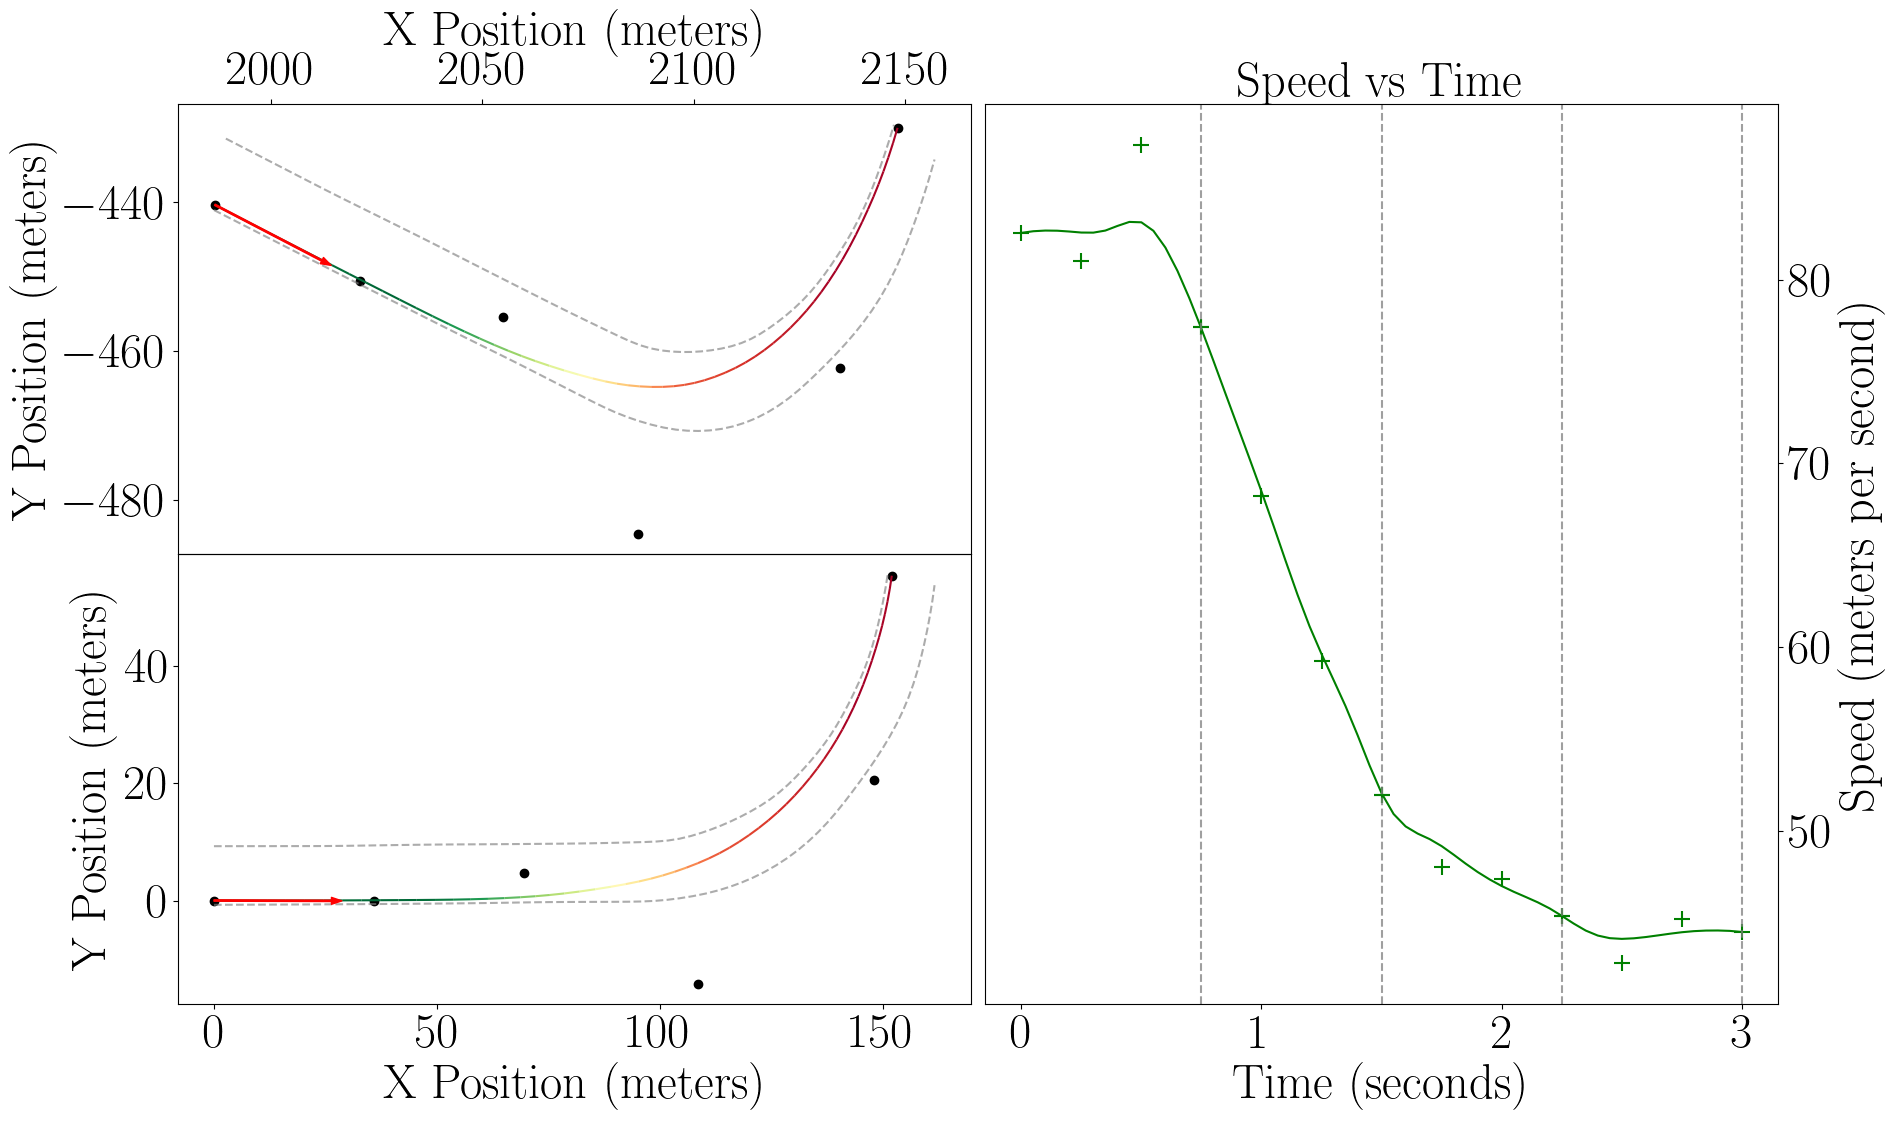

In [31]:
%autoreload 2
# idxrand = int(np.random.randint(0, high=composite_results["predictions"].shape[0]))
# idxrand=100821
#idxrand=98990
idxrand=70561
# idxrand=75440
#idxrand=72615
#idxrand =97544
print(idxrand)
sample = fulldset[idxrand]
plt.rc('font', size=18)
plt.rc('font', family="serif")
plt.rc('font', weight="medium")
plt.rc('text', usetex=True)
plt.rc('mathtext', default="regular")
future_local = torch.as_tensor(sample["fut"], dtype=torch.float64)
thistory=torch.as_tensor(sample["thistory"], dtype=future_local.dtype)
tfuture=torch.as_tensor(sample["tfuture"], dtype=future_local.dtype)
future_vels_local = torch.as_tensor(sample["fut_vel"], dtype=future_local.dtype)
future_tangent_local = torch.as_tensor(sample["fut_tangents"], dtype=future_local.dtype)
future_arclength = torch.as_tensor(sample["future_arclength"], dtype=future_local.dtype)
left_bd_local = torch.as_tensor(sample["future_left_bd"], dtype=future_local.dtype)
left_bd_tangent_local = torch.as_tensor(sample["future_left_bd_tangents"], dtype=future_local.dtype)
left_bd_arclength = torch.as_tensor(sample["future_left_bd_arclength"], dtype=future_local.dtype)
right_bd_local = torch.as_tensor(sample["future_right_bd"], dtype=future_local.dtype)
right_bd_tangent_local = torch.as_tensor(sample["future_right_bd_tangents"], dtype=future_local.dtype)
right_bd_arclength = torch.as_tensor(sample["future_right_bd_arclength"], dtype=future_local.dtype)

t0 = float(tfuture[0].item())
thistory = thistory - t0
tfuture = tfuture - t0

origin = torch.as_tensor(sample["current_position"], dtype=future_local.dtype)
quat = torch.as_tensor(sample["current_orientation"], dtype=future_local.dtype)
rot = Rotation.from_quat(quat.cpu().numpy())
rotmat = torch.as_tensor(rot.as_matrix(), dtype=future_local.dtype)


future = future_local @ rotmat.T + origin
future_vels = future_vels_local @ rotmat.T
left_bd = left_bd_local @ rotmat.T + origin
right_bd = right_bd_local @ rotmat.T + origin

future_tangent = future_tangent_local @ rotmat.T
right_bd_tangent = right_bd_tangent_local @ rotmat.T 
left_bd_tangent = left_bd_tangent_local @ rotmat.T

all_three = torch.stack([future, left_bd, right_bd], dim=0)
all_three_tangents = torch.stack([future_tangent, left_bd_tangent, right_bd_tangent], dim=0)
all_three_arclength = torch.stack([future_arclength, left_bd_arclength, right_bd_arclength], dim=0)

kbezier=5
Mall_curves, all_curves = mu.bezierLsqfit(all_three, kbezier, t=all_three_arclength,
                                           P0=all_three[:,0], 
                                           V0=all_three_tangents[:,0], 
                                           Pf=all_three[:,-1], 
                                           )
all_curves_local = (all_curves @ rotmat) - (rotmat.T @ origin)
try:
    plt.close(fig=fig) # type: ignore
    plt.close(fig=fig_cb) # type: ignore
except:
    pass

gt_speeds = torch.norm(future_vels, p=2.0, dim=1)
norm = plt.Normalize(gt_speeds.min(), gt_speeds.max(), clip=True)
cmap = "RdYlGn"
scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
from utils import add_colored_line
fig = plt.figure(figsize=[16,9])
gridspecsize=(100,100)
splitspace = .0
toprowend = int(round((0.5-splitspace)*gridspecsize[0]))
bottomrowstart = int(round((0.5+splitspace)*gridspecsize[0]))
left, right, bottom, top = 0, 1, 0, 1 #, hspace=0.15*gridspecsize[0], wspace=2.0*gridspecsize[1]
gs = GridSpec(*gridspecsize, figure=fig, hspace=0.0, wspace=.1*gridspecsize[1],
              left=left, right=right, bottom=bottom, top=top)
ax = fig.add_subplot(gs[0:toprowend,0:int(round(gridspecsize[0]/2))])
gt_lc, gt_line = add_colored_line(future[:,[0,1]].cpu().numpy(), gt_speeds.cpu().numpy(), ax, cmap)

arrowprops = dict(edgecolor='red', facecolor='red')
arrowprops["width"] = 1.0
arrowprops["headwidth"] = 5.0
arrowprops["headlength"] = 7.5
delta01 = (all_curves[0,1] - all_curves[0,0])
Pf = all_curves[0,0] + 0.8*delta01
ax.annotate("", Pf[:2].cpu().numpy(), xytext=origin[:2].cpu().numpy(), arrowprops=arrowprops)

ax.scatter(all_curves[0,:,0], all_curves[0,:,1], c="black")
lbartist, = ax.plot(left_bd[:,0], left_bd[:,1], color="grey", linestyle="--", alpha=0.65)
rbartist, = ax.plot(right_bd[:,0], right_bd[:,1], linestyle=lbartist.get_linestyle(), alpha=lbartist.get_alpha(), color=lbartist.get_color())
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
labelsize = 24
ax.set_xlabel("X Position (meters)", fontsize=labelsize)
ax.set_ylabel("Y Position (meters)", fontsize=labelsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)

ax_local = fig.add_subplot(gs[bottomrowstart:,:int(round(gridspecsize[0]/2))])
gt_lc_local, gt_line_local = add_colored_line(future_local[:,[0,1]].cpu().numpy(), gt_speeds.cpu().numpy(), ax_local, cmap)
lbartist, = ax_local.plot(left_bd_local[:,0], left_bd_local[:,1], color="grey", linestyle="--", alpha=0.65)
rbartist, = ax_local.plot(right_bd_local[:,0], right_bd_local[:,1], linestyle=lbartist.get_linestyle(), alpha=lbartist.get_alpha(), color=lbartist.get_color())
ax_local.annotate("", .8*all_curves_local[0,1,[0,1]].cpu().numpy(), xytext=np.zeros(2), arrowprops=arrowprops)
ax_local.set_xlabel("X Position (meters)", fontsize=labelsize)
ax_local.set_ylabel("Y Position (meters)", fontsize=labelsize)
ax_local.tick_params(axis='both', which='major', labelsize=labelsize)

gt_controlpoints_local = ax_local.scatter(all_curves_local[0,:,0], all_curves_local[0,:,1], c="black")

Nseg=4
nu_t, tswitch = mu.compositeBezierFit(tfuture, gt_speeds.unsqueeze(-1), Nseg, constraint_level=1, kbezier=3)
tstart = tswitch[:-1]
tend = tswitch[1:]
dt = tend - tstart
teval = torch.linspace(tfuture[0], tfuture[-1], steps=60)
speed_eval, _ = mu.compositeBezierEval(tstart, dt, nu_t, teval)
ax_speed = fig.add_subplot(gs[:int(round(1.0*gridspecsize[0])),int(round(gridspecsize[0]/2)):])
# speedartist = ax_speed.scatter(tfuture, gt_speeds, c="green", s=1.0)
speedartist, = ax_speed.plot(tfuture, gt_speeds, color="green")
# evalartist, = ax_speed.plot(teval, speed_eval, color=speedartist.get_color())
for (i,t) in enumerate(tswitch[:].cpu().numpy().tolist()):
    ax_speed.axvline(t, color="grey", linestyle="--", alpha=0.75) if i>0 else None
    if i>=Nseg:
        continue
    tcurr = torch.linspace(tswitch[i], tswitch[i+1], steps=nu_t.shape[1])
    ax_speed.scatter(tcurr, nu_t[i].squeeze(-1), c=speedartist.get_color(), marker="+", s=2**7.0)

ax_speed.set_ylabel("Speed (meters per second)", fontsize=labelsize)
ax_speed.yaxis.tick_right()
ax_speed.yaxis.set_label_position("right")
ax_speed.set_xlabel("Time (seconds)", fontsize=labelsize)
ax_speed.set_title("Speed vs Time", fontsize=labelsize)
ax_speed.tick_params(axis='both', which='major', labelsize=labelsize)

fig.savefig(os.path.join(plots_dir, "global_local.svg"), transparent=True, pad_inches=0.0, bbox_inches='tight')

from utils import export_legend
with plt.rc_context({"text.usetex" : True}) as ctx:
    gt_line_local.set_label("$\\mathbf{B}_r$")
    gt_controlpoints_local.set_label("Control Points")
    fig_legend, ax_legend, bbox = export_legend(ax_local)
    fig_legend.savefig(os.path.join(plots_dir, "global_local_legend.svg"), bbox_inches=bbox, dpi="figure", transparent=True)
    plt.close(fig=fig_legend)

mainfigsize = fig.get_size_inches()

with plt.rc_context({"text.usetex" : False}) as ctx:
    fig_cb, ax_cb = plt.subplots(figsize=[0.375*mainfigsize[0],.25])
    fig_cb.colorbar(scalar_mappable, cax=ax_cb, orientation="horizontal", pad=0.0, fraction=1.0)
    fig_cb.savefig(os.path.join(plots_dir, "global_local_cb.svg"), transparent=True, pad_inches=0.02)
    plt.close(fig=fig_cb)

import matplotlib.font_manager
matplotlib.font_manager.get_font_names()
